_Will Kaufman, September 30 2020_

The following analyses were done on a water sample in a Bruker 9.4T magnet.

In [1]:
import os
import  numpy as np
from scipy.optimize import curve_fit
import nmrglue as ng

import matplotlib.pyplot as plt

In [2]:
def plot_spectrum(data_p, indices=None):
    x = np.linspace(data_p[0]['procs']['F1P'],
                    data_p[0]['procs']['F2P'],
                    data_p[0]['procs']['FTSIZE'])
    y = data_p[1]
    if indices is not None:
        x = x[indices[0]:indices[1]]
        y = y[indices[0]:indices[1]]
    plt.plot(x, y)

In [3]:
def read_raw(data_dir, expno):
    return ng.bruker.read(os.path.join(data_dir, str(expno)))

In [4]:
def read_processed(data_dir, expno):
    return ng.bruker.read_pdata(os.path.join(data_dir, str(expno), 'pdata', '1'))

## Estimating $\pi/2$ pulse length

To estimate the $\pi/2$ pulse length (with fixed power of 15W), a series of experiments were run that applied a pulse with lengths varying from 0 to 40$\mu$s. The resulting signal amplitudes were then plotted versus pulse length, and a $\sin$ function
$$
S(t_\text{pulse}) = S_0 \sin(\alpha t_\text{pulse})
$$
was fitted to the data by estimating $S_0$ and $\alpha$.
The pulse length for a $\pi/2$ pulse can then be determined by
$$
t_{\pi/2} = \frac{\pi}{2 \alpha}
$$

In [6]:
data_dir = '../data/2020-09-22/tarfile'

The signal amplitude is calculated by integrating the spectrum (Fourier transform of the free induction decay).

In [13]:
data_p = read_processed(data_dir, 3038)

In [11]:
data_p[1]

array([-0.36324948, -3.91679755, -2.78244758, ...,  1.14798751,
        3.543919  , -3.42458677])

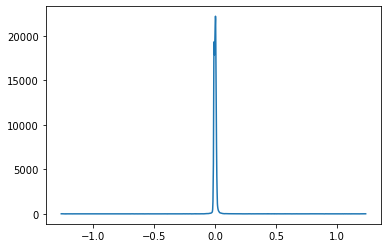

In [21]:
plot_spectrum(data_p)

In [6]:
amplitudes = np.zeros((40,))
for i in range(40):
    data_p = read_processed(data_dir, 3014 + i)
    amplitudes[i] = np.sum(data_p[1])

In [7]:
fit = curve_fit(lambda t, S0, alpha: S0 * np.sin(alpha * t), np.linspace(0, 40e-6, 40), amplitudes)

The estimates and standard errors for $S_0$ and $\alpha$ are given below.

In [8]:
estimates = fit[0]
std_errs = np.sqrt(np.diag(fit[1]))
print(estimates)  # estimates
print(std_errs)  # standard errors

[422735.39429935  53624.94358371]
[80.50019944 16.13505729]


Text(0, 0.5, 'Signal amplitude')

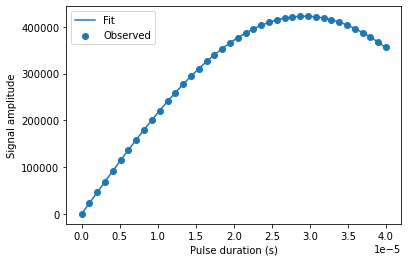

In [9]:
t = np.linspace(0, 40e-6, 40)
plt.scatter(t, amplitudes, label='Observed')
plt.plot(t, fit[0][0] * np.sin(fit[0][1] * t), label='Fit')
plt.legend()
plt.xlabel('Pulse duration (s)')
plt.ylabel('Signal amplitude')

In [23]:
t_pi2 = np.pi / (2 * estimates[1])
print(f'{t_pi2 : .04e}')  # estimate for pi/2 hard pulse length

 2.9292e-05


In [11]:
print(f'{t_pi2 * std_errs[1] / estimates[1] : 0.01e}')  # standard error for pi/2 hard pulse length

 8.8e-09


The estimate for a $\pi/2$ pulse is $29.292 \pm 0.009 \mu$s.

## Estimating T1

In [12]:
data_dir = '../data/2020-09-30/runs/'

In [13]:
amplitudes_t1 = np.zeros((100,))
for i in range(100):
    data_p = read_processed(data_dir, 204 + i)
    amplitudes_t1[i] = np.sum(data_p[1])

In [14]:
delays_t1 = np.linspace(10e-6, 2, 100)

In [15]:
fit_t1 = curve_fit(lambda t, a, tau, c: a * np.exp(-t / tau) + c,
                   delays_t1[delays_t1>.1], amplitudes_t1[delays_t1>.1],
                   p0=(8e5, 1, -4e5))

In [16]:
estimates_t1 = fit_t1[0]
std_errs_t1 = np.sqrt(np.diag(fit_t1[1]))
print(estimates_t1)
print(std_errs_t1)

[ 7.78092877e+05  9.43706495e-01 -4.31110078e+05]
[9.55137268e+02 4.11128279e-03 1.28727282e+03]


Then the estimate for $T_1 = 0.944 \pm .004$s.

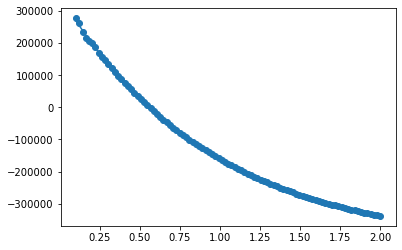

In [17]:
plt.scatter(delays_t1[delays_t1>.1], amplitudes_t1[delays_t1>.1])
plt.plot(delays_t1[delays_t1>.1], fit_t1[0][0] * np.exp(-delays_t1[delays_t1>.1] / fit_t1[0][1]) + fit_t1[0][2])

## Estimating T2

In [18]:
amplitudes_t2 = np.zeros((100,))
for i in range(100):
    data_p = read_processed(data_dir, 305 + i)
    amplitudes_t2[i] = np.sum(data_p[1])

In [19]:
delays_t2 = np.linspace(10e-6, 1.5, 100)

In [20]:
fit_t2 = curve_fit(lambda t, a, tau, c: a * np.exp(-t / tau) + c,
                   delays_t2[delays_t2>0.2], amplitudes_t2[delays_t2>0.2],
                   p0=(3e5, 1, 0))

In [21]:
estimates_t2 = fit_t2[0]
std_errs_t2 = np.sqrt(np.diag(fit_t2[1]))
print(estimates_t2)
print(std_errs_t2)

[ 3.96020833e+05  3.28247162e-01 -1.50506972e+03]
[8.67202838e+02 8.81694931e-04 1.39386868e+02]


The estimate for $T_2 = 0.3282 \pm 0.0009$s.

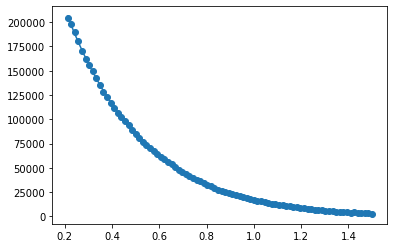

In [22]:
plt.scatter(delays_t2[delays_t2>0.2], amplitudes_t2[delays_t2>0.2])
plt.plot(delays_t2[delays_t2>0.2], fit_t2[0][0] * np.exp(-delays_t2[delays_t2>0.2] / fit_t2[0][1]) + fit_t2[0][2])